## Import Tools

In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io 
import random
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import seaborn as sn
import pandas as pd
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

## Dataset Processing 

### Read in the original dataset 

In [2]:
train_dl_origin = torch.load('train_dl.pt')
valid_dl_origin = torch.load('valid_dl.pt')

train_CSI = train_dl_origin.dataset[:][0]
train_label = train_dl_origin.dataset[:][1][:,2].type(torch.LongTensor)

valid_CSI = valid_dl_origin.dataset[:][0]
valid_label = valid_dl_origin.dataset[:][1][:,2].type(torch.LongTensor)

### CSI Processing Method 1: Take Modulus of complex matrices

In [3]:
train_CSI_modulus = torch.abs(train_CSI)
valid_CSI_modulus = torch.abs(valid_CSI)

### Show the size of the training and valiation dataset

In [4]:
print(train_CSI_modulus.shape)
print(valid_CSI_modulus.shape)

torch.Size([15000, 1, 4, 1632])
torch.Size([5000, 1, 4, 1632])


### Show a pilot signal in frequence domain

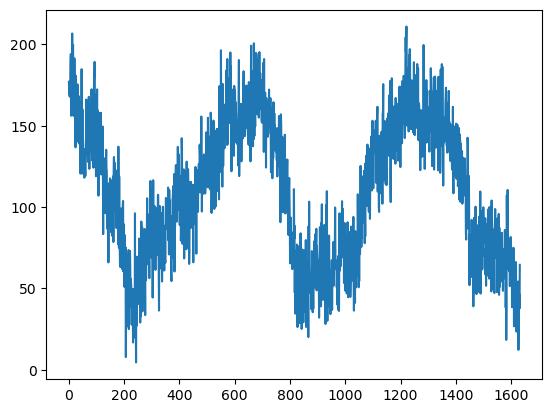

In [5]:
plt.plot(train_CSI_modulus[1,0,0,:])

### You can try different CSI processing methods here:
#### 1. Use FFT to change frequency CSI to time domain CSI 
#### 2. Calculate the total Power of the CSI signal 

In [7]:
# Time domain CSI
train_CSI_time = torch.fft.ifft(train_CSI, n=1632, dim=-1)
valid_CSI_time = torch.fft.ifft(valid_CSI, n=1632, dim=-1)

# Total power of the CSI signal
train_CSI_power = torch.sum(train_CSI_modulus**2, dim=-1)
valid_CSI_power = torch.sum(valid_CSI_modulus**2, dim=-1)

power =  tensor([[[3.6081e+07, 3.5098e+07, 5.6075e+07, 8.3282e+06]],

        [[2.3079e+07, 1.4888e+07, 2.3085e+07, 3.8798e+06]],

        [[4.7158e+08, 4.2777e+08, 8.3283e+08, 1.9061e+08]],

        ...,

        [[1.0086e+08, 1.1325e+08, 1.8123e+08, 2.6042e+07]],

        [[8.7940e+07, 5.7685e+07, 6.4700e+07, 2.2065e+07]],

        [[1.5685e+08, 6.8952e+07, 1.2901e+08, 3.3274e+07]]])


###  CSI Processing: Normalize to [0,1]

In [12]:
max_value_train = torch.max(train_CSI_modulus)
min_value_train = torch.min(train_CSI_modulus)
range_value = max_value_train - min_value_train

train_CSI_normalize = (train_CSI_modulus - min_value_train)/range_value
valid_CSI_normalize = (valid_CSI_modulus - min_value_train)/range_value

## Define a neural network model and train the model

In [13]:
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4*1632, 512)  # 4*1632 input nodes, 512 output nodes
        self.fc2 = nn.Linear(512, 128)     # 512 input nodes, 128 output nodes
        self.fc3 = nn.Linear(128, 2)       # 128 input nodes, 2 output nodes (LoS and NLoS)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

X_train = train_CSI_normalize.view(-1, 4*1632)  # Reshaping into 2D
y_train = train_label
X_valid = valid_CSI_normalize.view(-1, 4*1632)
y_valid = valid_label

# Training
for epoch in range(20):  
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{100}, Loss: {loss.item()}')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_valid)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_valid).sum().item() / y_valid.size(0)
    print(f'Validation Accuracy: {accuracy * 100}%')


Epoch 1/100, Loss: 0.6618015766143799
Epoch 2/100, Loss: 0.6611731052398682
Epoch 3/100, Loss: 0.6605485677719116
Epoch 4/100, Loss: 0.6599279046058655
Epoch 5/100, Loss: 0.6593115925788879
Epoch 6/100, Loss: 0.6586998105049133
Epoch 7/100, Loss: 0.6580923795700073
Epoch 8/100, Loss: 0.6574889421463013
Epoch 9/100, Loss: 0.6568886637687683
Epoch 10/100, Loss: 0.656291663646698
Epoch 11/100, Loss: 0.655697762966156
Epoch 12/100, Loss: 0.6551067233085632
Epoch 13/100, Loss: 0.6545189023017883
Epoch 14/100, Loss: 0.653933584690094
Epoch 15/100, Loss: 0.6533514261245728
Epoch 16/100, Loss: 0.652772068977356
Epoch 17/100, Loss: 0.6521956324577332
Epoch 18/100, Loss: 0.65162193775177
Epoch 19/100, Loss: 0.651050865650177
Epoch 20/100, Loss: 0.6504825949668884
Validation Accuracy: 81.28%


In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 512)  # 1 input node, 512 output nodes
        self.fc2 = nn.Linear(512, 128)  # 512 input nodes, 128 output nodes
        self.fc3 = nn.Linear(128, 2)  # 128 input nodes, 2 output nodes (LoS and NLoS)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
# Power of CSI as INPUT

# Reshape the data to 2D and sum the power across the antennas and sub-carriers for each sample
X_train_power = train_CSI_power.sum(dim=[1, 2]).view(-1, 1)
X_valid_power = valid_CSI_power.sum(dim=[1, 2]).view(-1, 1)

model_power = Net()
optimizer = optim.SGD(model_power.parameters(), lr=0.001)


for epoch in range(20): 
    optimizer.zero_grad()
    outputs = model_power(X_train_power)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{20}, Loss: {loss.item()}')

model_power.eval()
with torch.no_grad():
    outputs = model_power(X_valid_power)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_valid).sum().item() / y_valid.size(0)
    print(f'Validation Accuracy with Power of CSI as Input: {accuracy * 100}%')

Epoch 1/20, Loss: 176030096.0
Epoch 2/20, Loss: 2.225424659008658e+25
Epoch 3/20, Loss: 49524632.0
Epoch 4/20, Loss: 588822912.0
Epoch 5/20, Loss: 461903488.0
Epoch 6/20, Loss: 334984352.0
Epoch 7/20, Loss: 208065280.0
Epoch 8/20, Loss: 81146288.0
Epoch 9/20, Loss: 0.7170279026031494
Epoch 10/20, Loss: 0.7167910933494568
Epoch 11/20, Loss: 0.7165547609329224
Epoch 12/20, Loss: 0.7163187265396118
Epoch 13/20, Loss: 0.7160826921463013
Epoch 14/20, Loss: 0.7158469557762146
Epoch 15/20, Loss: 0.7156115174293518
Epoch 16/20, Loss: 0.7153763175010681
Epoch 17/20, Loss: 0.7151414752006531
Epoch 18/20, Loss: 0.714906632900238
Epoch 19/20, Loss: 0.7146722078323364
Epoch 20/20, Loss: 0.7144377827644348
Validation Accuracy with Power of CSI as Input: 18.72%


In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4*1632, 512)  # 4*1632 input nodes, 512 output nodes
        self.fc2 = nn.Linear(512, 128)  # 512 input nodes, 128 output nodes
        self.fc3 = nn.Linear(128, 2)  # 128 input nodes, 2 output nodes (LoS and NLoS)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
# Time Domain CSI as INPUT

X_train_time_abs = torch.abs(train_CSI_time).view(-1, 4*1632)
X_valid_time_abs = torch.abs(valid_CSI_time).view(-1, 4*1632)

model_time = Net()
optimizer = optim.SGD(model_time.parameters(), lr=0.001)

for epoch in range(20):  
    optimizer.zero_grad()
    outputs = model_time(X_train_time_abs)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{20}, Loss: {loss.item()}')

model_time.eval()
with torch.no_grad():
    outputs = model_time(X_valid_time_abs)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_valid).sum().item() / y_valid.size(0)
    print(f'Validation Accuracy with Time Domain CSI as Input: {accuracy * 100}%')

Epoch 1/20, Loss: 0.968691885471344
Epoch 2/20, Loss: 0.534308910369873
Epoch 3/20, Loss: 0.5169869661331177
Epoch 4/20, Loss: 0.5051239728927612
Epoch 5/20, Loss: 0.49585098028182983
Epoch 6/20, Loss: 0.4881400167942047
Epoch 7/20, Loss: 0.4815206527709961
Epoch 8/20, Loss: 0.4757310748100281
Epoch 9/20, Loss: 0.47058337926864624
Epoch 10/20, Loss: 0.4659697711467743
Epoch 11/20, Loss: 0.4617997109889984
Epoch 12/20, Loss: 0.45800554752349854
Epoch 13/20, Loss: 0.45454564690589905
Epoch 14/20, Loss: 0.4513736963272095
Epoch 15/20, Loss: 0.44844815135002136
Epoch 16/20, Loss: 0.44573792815208435
Epoch 17/20, Loss: 0.4432162344455719
Epoch 18/20, Loss: 0.44086527824401855
Epoch 19/20, Loss: 0.4386601150035858
Epoch 20/20, Loss: 0.4365863800048828
Validation Accuracy with Time Domain CSI as Input: 80.96%


In [23]:
# Frequency Domain CSI as INPUT

X_train_freq_abs = torch.abs(train_CSI).view(-1, 4*1632)
X_valid_freq_abs = torch.abs(valid_CSI).view(-1, 4*1632)


model_freq = Net()
optimizer = optim.SGD(model_freq.parameters(), lr=0.001)

for epoch in range(20):  
    optimizer.zero_grad()
    outputs = model_freq(X_train_freq_abs)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{20}, Loss: {loss.item()}')

model_freq.eval()
with torch.no_grad():
    outputs = model_freq(X_valid_freq_abs)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_valid).sum().item() / y_valid.size(0)
    print(f'Validation Accuracy with Frequency Domain CSI as Input: {accuracy * 100}%')

Epoch 1/20, Loss: 7.848504066467285
Epoch 2/20, Loss: 4244.90283203125
Epoch 3/20, Loss: 19587.08203125
Epoch 4/20, Loss: 1145.85400390625
Epoch 5/20, Loss: 589306.1875
Epoch 6/20, Loss: 13194.53515625
Epoch 7/20, Loss: 4226810.5
Epoch 8/20, Loss: 145206832.0
Epoch 9/20, Loss: 1387177.5
Epoch 10/20, Loss: 2542144768.0
Epoch 11/20, Loss: 13851124826112.0
Epoch 12/20, Loss: 872951906304.0
Epoch 13/20, Loss: 4.974206495437619e+16
Epoch 14/20, Loss: 45759197184.0
Epoch 15/20, Loss: 70.79435729980469
Epoch 16/20, Loss: 56.27229690551758
Epoch 17/20, Loss: 41.75026321411133
Epoch 18/20, Loss: 27.228235244750977
Epoch 19/20, Loss: 12.706218719482422
Epoch 20/20, Loss: 0.48766130208969116
Validation Accuracy with Frequency Domain CSI as Input: 81.26%
Validation Accuracy with Frequency Domain CSI as Input: 81.26%


In [28]:
# Vehicle Positioning Program

train_coords = train_dl_origin.dataset[:][1][:,:2]  
valid_coords = valid_dl_origin.dataset[:][1][:,:2]

# Model Design

class PositionNet(nn.Module):
    def __init__(self):
        super(PositionNet, self).__init__()
        self.fc1 = nn.Linear(4*1632, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2) 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  
        return x
    

model_position = PositionNet()
optimizer = optim.SGD(model_position.parameters(), lr=0.0001)
criterion = nn.MSELoss()

for epoch in range(20):  
    optimizer.zero_grad()
    outputs = model_position(X_train_freq_abs)
    loss = criterion(outputs, train_coords)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{20}, Loss: {loss.item()}')

Epoch 1/20, Loss: 3019.373291015625
Epoch 2/20, Loss: 3331815112704.0
Epoch 3/20, Loss: inf
Epoch 4/20, Loss: nan
Epoch 5/20, Loss: nan
Epoch 6/20, Loss: nan
Epoch 7/20, Loss: nan
Epoch 8/20, Loss: nan
Epoch 9/20, Loss: nan
Epoch 10/20, Loss: nan
Epoch 11/20, Loss: nan
Epoch 12/20, Loss: nan
Epoch 13/20, Loss: nan
Epoch 14/20, Loss: nan
Epoch 15/20, Loss: nan
Epoch 16/20, Loss: nan
Epoch 17/20, Loss: nan
Epoch 18/20, Loss: nan
Epoch 19/20, Loss: nan
Epoch 20/20, Loss: nan


In [29]:
model_position.eval()
with torch.no_grad():
    outputs = model_position(X_valid_freq_abs)
    loss = criterion(outputs, valid_coords)
    print(f'Validation MSE Loss: {loss.item()}')

Validation MSE Loss: nan


In [32]:
# Vehicle Positioning Program
train_coords = train_dl_origin.dataset[:][1][:,:2]  # First two dimensions are x and y coordinates
valid_coords = valid_dl_origin.dataset[:][1][:,:2]

train_coords = (train_coords - torch.mean(train_coords, dim=0)) / torch.std(train_coords, dim=0)
valid_coords = (valid_coords - torch.mean(valid_coords, dim=0)) / torch.std(valid_coords, dim=0)

class PositionNet(nn.Module):
    def __init__(self):
        super(PositionNet, self).__init__()
        self.fc1 = nn.Linear(4*1632, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)  
        self.dropout = nn.Dropout(0.5)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  
        x = self.fc3(x) 
        return x


model_position = PositionNet()
optimizer = optim.SGD(model_position.parameters(), lr=0.00001)  # Reduced learning rate
criterion = nn.MSELoss()

for epoch in range(20):  
    optimizer.zero_grad()
    outputs = model_position(X_train_freq_abs)
    loss = criterion(outputs, train_coords)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{20}, Loss: {loss.item()}')

Epoch 1/20, Loss: 5375.54541015625
Epoch 2/20, Loss: 14093705.0
Epoch 3/20, Loss: 4.240580296929444e+17
Epoch 4/20, Loss: inf
Epoch 5/20, Loss: nan
Epoch 6/20, Loss: nan
Epoch 7/20, Loss: nan
Epoch 8/20, Loss: nan
Epoch 9/20, Loss: nan
Epoch 10/20, Loss: nan
Epoch 11/20, Loss: nan
Epoch 12/20, Loss: nan
Epoch 13/20, Loss: nan
Epoch 14/20, Loss: nan
Epoch 15/20, Loss: nan
Epoch 16/20, Loss: nan
Epoch 17/20, Loss: nan
Epoch 18/20, Loss: nan
Epoch 19/20, Loss: nan
Epoch 20/20, Loss: nan


In [33]:
train_coords = train_dl_origin.dataset[:][1][:,:2]  
valid_coords = valid_dl_origin.dataset[:][1][:,:2]

train_coords = (train_coords - torch.mean(train_coords, dim=0)) / torch.std(train_coords, dim=0)
valid_coords = (valid_coords - torch.mean(valid_coords, dim=0)) / torch.std(valid_coords, dim=0)


class PositionNet(nn.Module):
    def __init__(self):
        super(PositionNet, self).__init__()
        self.fc1 = nn.Linear(4*1632, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)  
        self.dropout = nn.Dropout(0.5)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x) 
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  
        x = self.fc3(x)  
        return x


model_position = PositionNet()
optimizer = optim.SGD(model_position.parameters(), lr=0.00001) 
criterion = nn.MSELoss()

# Train the model
for epoch in range(20):  # Number of epochs
    optimizer.zero_grad()
    outputs = model_position(X_train_freq_abs)
    loss = criterion(outputs, train_coords)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{20}, Loss: {loss.item()}')

Epoch 1/20, Loss: 6020.900390625
Epoch 2/20, Loss: 58749340.0
Epoch 3/20, Loss: 7.64327707071742e+20
Epoch 4/20, Loss: inf
Epoch 5/20, Loss: nan
Epoch 6/20, Loss: nan
Epoch 7/20, Loss: nan
Epoch 8/20, Loss: nan
Epoch 9/20, Loss: nan
Epoch 10/20, Loss: nan
Epoch 11/20, Loss: nan
Epoch 12/20, Loss: nan
Epoch 13/20, Loss: nan
Epoch 14/20, Loss: nan
Epoch 15/20, Loss: nan
Epoch 16/20, Loss: nan
Epoch 17/20, Loss: nan
Epoch 18/20, Loss: nan
Epoch 19/20, Loss: nan
Epoch 20/20, Loss: nan


In [34]:
# Vehicle Positioning Program
# Sol 1: Gradient Clipping

train_coords = train_dl_origin.dataset[:][1][:,:2]  
valid_coords = valid_dl_origin.dataset[:][1][:,:2]

train_coords = (train_coords - torch.mean(train_coords, dim=0)) / torch.std(train_coords, dim=0)
valid_coords = (valid_coords - torch.mean(valid_coords, dim=0)) / torch.std(valid_coords, dim=0)

class PositionNet(nn.Module):
    def __init__(self):
        super(PositionNet, self).__init__()
        self.fc1 = nn.Linear(4*1632, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)  
        self.dropout = nn.Dropout(0.5)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  
        x = self.fc3(x)  
        return x

model_position = PositionNet()
optimizer = optim.SGD(model_position.parameters(), lr=0.00001)
criterion = nn.MSELoss()

for epoch in range(20):
    optimizer.zero_grad()
    outputs = model_position(X_train_freq_abs)
    loss = criterion(outputs, train_coords)
    loss.backward()
    
    # Clip the gradient
    torch.nn.utils.clip_grad_norm_(model_position.parameters(), max_norm=1)
    
    optimizer.step()
    print(f'Epoch {epoch+1}/{20}, Loss: {loss.item()}')


Epoch 1/20, Loss: 4588.72705078125
Epoch 2/20, Loss: 4494.57958984375
Epoch 3/20, Loss: 4473.93408203125
Epoch 4/20, Loss: 4503.8330078125
Epoch 5/20, Loss: 4452.806640625
Epoch 6/20, Loss: 4441.05517578125
Epoch 7/20, Loss: 4522.12890625
Epoch 8/20, Loss: 4500.447265625
Epoch 9/20, Loss: 4508.9658203125
Epoch 10/20, Loss: 4556.70654296875
Epoch 11/20, Loss: 4501.9677734375
Epoch 12/20, Loss: 4471.20556640625
Epoch 13/20, Loss: 4469.345703125
Epoch 14/20, Loss: 4517.2607421875
Epoch 15/20, Loss: 4538.8798828125
Epoch 16/20, Loss: 4472.81005859375
Epoch 17/20, Loss: 4494.0498046875
Epoch 18/20, Loss: 4471.68994140625
Epoch 19/20, Loss: 4618.6748046875
Epoch 20/20, Loss: 4530.31689453125


In [36]:
model_position.eval()
with torch.no_grad():
    outputs = model_position(X_valid_freq_abs)
    loss = criterion(outputs, valid_coords)
    print(f'Validation MSE Loss after applying Gradient Clipping: {loss.item()}')

Validation MSE Loss after applying Gradient Clipping: 147.82440185546875


In [37]:
# Sol 2: Learning Rate Scheduling

train_coords = train_dl_origin.dataset[:][1][:,:2]  
valid_coords = valid_dl_origin.dataset[:][1][:,:2]

train_coords = (train_coords - torch.mean(train_coords, dim=0)) / torch.std(train_coords, dim=0)
valid_coords = (valid_coords - torch.mean(valid_coords, dim=0)) / torch.std(valid_coords, dim=0)

class PositionNet(nn.Module):
    def __init__(self):
        super(PositionNet, self).__init__()
        self.fc1 = nn.Linear(4*1632, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)  
        self.dropout = nn.Dropout(0.5)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = F.relu(self.fc2(x))
        x = self.dropout(x) 
        x = self.fc3(x)  
        return x

model_position = PositionNet()
optimizer = optim.SGD(model_position.parameters(), lr=0.00001)
criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(20):
    optimizer.zero_grad()
    outputs = model_position(X_train_freq_abs)
    loss = criterion(outputs, train_coords)
    loss.backward()
    optimizer.step()
    
    # Step the learning rate scheduler
    scheduler.step()
    
    print(f'Epoch {epoch+1}/{20}, Loss: {loss.item()}')


Epoch 1/20, Loss: 3636.274658203125
Epoch 2/20, Loss: 761698.3125
Epoch 3/20, Loss: 47389863837696.0
Epoch 4/20, Loss: inf
Epoch 5/20, Loss: nan
Epoch 6/20, Loss: nan
Epoch 7/20, Loss: nan
Epoch 8/20, Loss: nan
Epoch 9/20, Loss: nan
Epoch 10/20, Loss: nan
Epoch 11/20, Loss: nan
Epoch 12/20, Loss: nan
Epoch 13/20, Loss: nan
Epoch 14/20, Loss: nan
Epoch 15/20, Loss: nan
Epoch 16/20, Loss: nan
Epoch 17/20, Loss: nan
Epoch 18/20, Loss: nan
Epoch 19/20, Loss: nan
Epoch 20/20, Loss: nan


In [40]:
# Sol 3: Different Optimizer (Adam)

train_coords = train_dl_origin.dataset[:][1][:,:2]  
valid_coords = valid_dl_origin.dataset[:][1][:,:2]

train_coords = (train_coords - torch.mean(train_coords, dim=0)) / torch.std(train_coords, dim=0)
valid_coords = (valid_coords - torch.mean(valid_coords, dim=0)) / torch.std(valid_coords, dim=0)

class PositionNet(nn.Module):
    def __init__(self):
        super(PositionNet, self).__init__()
        self.fc1 = nn.Linear(4*1632, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)  
        self.dropout = nn.Dropout(0.5)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  
        x = self.fc3(x)  
        return x

model_position = PositionNet()

# Use Adam optimizer
optimizer = torch.optim.Adam(model_position.parameters(), lr=0.0001)

criterion = nn.MSELoss()

for epoch in range(25):
    optimizer.zero_grad()
    outputs = model_position(X_train_freq_abs)
    loss = criterion(outputs, train_coords)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{25}, Loss: {loss.item()}')


Epoch 1/25, Loss: 4412.85693359375
Epoch 2/25, Loss: 15526.03125
Epoch 3/25, Loss: 1923.53955078125
Epoch 4/25, Loss: 2239.397705078125
Epoch 5/25, Loss: 2388.405029296875
Epoch 6/25, Loss: 2347.241943359375
Epoch 7/25, Loss: 2208.16357421875
Epoch 8/25, Loss: 2222.3193359375
Epoch 9/25, Loss: 2063.809326171875
Epoch 10/25, Loss: 1868.38232421875
Epoch 11/25, Loss: 1714.52783203125
Epoch 12/25, Loss: 1553.96044921875
Epoch 13/25, Loss: 1370.7938232421875
Epoch 14/25, Loss: 1294.9697265625
Epoch 15/25, Loss: 1128.17431640625
Epoch 16/25, Loss: 1001.71337890625
Epoch 17/25, Loss: 894.4698486328125
Epoch 18/25, Loss: 756.4754638671875
Epoch 19/25, Loss: 656.5401611328125
Epoch 20/25, Loss: 559.2646484375
Epoch 21/25, Loss: 482.78472900390625
Epoch 22/25, Loss: 417.0373229980469
Epoch 23/25, Loss: 352.4491271972656
Epoch 24/25, Loss: 305.2890625
Epoch 25/25, Loss: 271.6857604980469


In [41]:
model_position.eval()
with torch.no_grad():
    outputs = model_position(X_valid_freq_abs)
    loss = criterion(outputs, valid_coords)
    print(f'Validation MSE Loss after applying ADAM Optimizer: {loss.item()}')

Validation MSE Loss after applying ADAM Optimizer: 1.9668121337890625


In [42]:
import time

start_time = time.time()

for epoch in range(20): 
    optimizer.zero_grad()
    outputs = model_position(X_train_freq_abs)
    loss = criterion(outputs, train_coords)
    loss.backward()
    optimizer.step()

end_time = time.time()

print(f'Time used for training: {end_time - start_time} seconds')

Time used for training: 26.485426425933838 seconds


In [43]:
model_size = sum(p.numel() for p in model_position.parameters() if p.requires_grad)

print(f'Size of the model: {model_size} parameters')

Size of the model: 3408770 parameters


In [44]:
import time

start_time = time.time()

for epoch in range(20): 
    optimizer.zero_grad()
    outputs = model_position(X_train_time_abs)
    loss = criterion(outputs, train_coords)
    loss.backward()
    optimizer.step()

end_time = time.time()

print(f'Time used for training: {end_time - start_time} seconds')

Time used for training: 28.12173104286194 seconds


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
print(device)

cpu


In [54]:
print(CSI_modulus.shape)
print(label.shape)

torch.Size([1600, 1632])
torch.Size([400])
